# Triplet Neural Networks

The data must be images, in the form of (x_train, y_train), (x_val, y_val)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import pandas as pd
import os
import pickle
import random
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Lambda, GlobalAvgPool2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Auxiliary Functions

In [2]:
def normalize_images(images):
    return (images/255.0).astype('float32')

def augment_image(image):
    
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,    # Random rotation
        width_shift_range=0.2,  # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        shear_range=0.2,  # Shear transformation
        zoom_range=0.2,  # Zoom in/out
        #horizontal_flip=True,  # Random horizontal flip -> Be careful with MNIST data
        fill_mode='nearest'  # Fill mode for new pixels
    )
    
    image = np.expand_dims(image, axis=0)  
    augmented_image = datagen.flow(image, batch_size=1)[0]  
    return augmented_image[0]  

def create_image_triplets(x, y, n_triplets=2, augment=True):
    triplets = []
    labels = []  
    
    class_dict = {i: np.where(y == i)[0] for i in np.unique(y)}
    
    for class_label in np.unique(y):
        indices = class_dict[class_label]
        
        for idx in indices:
            anchor_img = np.copy(x[idx])  
            
            for _ in range(n_triplets):
                pos_idx = np.random.choice(indices, replace=False)
                positive_img = x[pos_idx]
                
                neg_class = np.random.choice(np.delete(np.unique(y), class_label))
                neg_idx = np.random.choice(class_dict[neg_class])
                negative_img = x[neg_idx]
                
                anchor_to_use = augment_image(anchor_img) if augment else anchor_img 
                positive_img = augment_image(positive_img) if augment else positive_img
                negative_img = augment_image(negative_img) if augment else negative_img
                
                triplets.append([anchor_to_use, positive_img, negative_img])
                labels.append((1, 0)) 
    
    triplets = np.array(triplets)
    labels = np.array(labels)
    return triplets, labels

def plot_image_triplets(triplets, num_samples=5):
    num_triplets = len(triplets)
    sampled_indices = np.random.choice(num_triplets, num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(9, num_samples * 3))
    for i, idx in enumerate(sampled_indices):
        anchor, positive, negative = triplets[idx]
        
        axes[i, 0].imshow(anchor, cmap='gray')
        axes[i, 1].imshow(positive, cmap='gray')
        axes[i, 2].imshow(negative, cmap='gray')
        
        for j in range(3):
            axes[i, j].axis('off')
        
        axes[i, 0].set_title('Anchor')
        axes[i, 1].set_title('Positive')
        axes[i, 2].set_title('Negative')
    
    plt.tight_layout()
    plt.show()

In [3]:
def reduce_dataset(x, y, samples_per_class=200):
    """Reduce the size of the dataset by sampling a fixed number of images per class."""
    reduced_x = []
    reduced_y = []
    
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        sampled_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        
        reduced_x.append(x[sampled_indices])
        reduced_y.append(y[sampled_indices])
    
    reduced_x = np.concatenate(reduced_x, axis=0)
    reduced_y = np.concatenate(reduced_y, axis=0)
    
    return reduced_x, reduced_y

In [4]:
def plot_random_images(images, labels, label_names, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        img = images[index]
        label = labels[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label_names[label].decode('utf-8'))
        plt.axis('off')
    plt.show()

# Data

## MNIST

In [5]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

## MNIST CHINESE

In [ ]:
csv_path = '../data/MNIST Chinese/chinese_mnist.csv'  
image_dir = '../data/MNIST Chinese/data/data/'  

In [ ]:
df = pd.read_csv(csv_path)

df['filename'] = df.apply(lambda row: f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg", axis=1)

image_data = []
for img_name in df['filename']:
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path).convert('L')
    img = np.array(img.resize((28, 28)))
    image_data.append(img)

x_train = np.array(image_data)
y_train = df['value'].values

x_train = normalize_images(x_train)

mapping = {100: 11, 1000: 12, 10000: 13, 100000000: 14}

y_train = np.array([mapping[label] if label in mapping else label for label in y_train])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
len(np.unique(y_train))

## CIFAR-10

In [ ]:
def load_cifar10_batch(batch_file):
    with open(batch_file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        images = images.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
        labels = np.array(labels)
        return images, labels

In [ ]:
data_dir = '../data/CIFAR-10/cifar-10-batches-py'
train_images = []
train_labels = []

In [ ]:
for i in range(1, 6):
    batch_file = os.path.join(data_dir, f'data_batch_{i}')
    images, labels = load_cifar10_batch(batch_file)
    train_images.append(images)
    train_labels.append(labels)

In [ ]:
x_train = np.concatenate(train_images)
y_train = np.concatenate(train_labels)

In [ ]:
x_val, y_val = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

In [ ]:
with open(os.path.join(data_dir, 'batches.meta'), 'rb') as f:
    label_meta = pickle.load(f, encoding='bytes')
    label_names = label_meta[b'label_names']

In [ ]:
print(f'Training data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Label names: {label_names}')

In [ ]:
plot_random_images(x_train, y_train, label_names, num_images=5)

# Preprocessing and Modelling

In [20]:
reduced_x_train, reduced_y_train = reduce_dataset(x_train, y_train, samples_per_class=10)

#reduced_x_train = normalize_images(reduced_x_train)
#x_val = normalize_images(x_val)

In [21]:
reduced_x_train.shape

(100, 28, 28)

In [22]:
pd.DataFrame(reduced_y_train).value_counts()

0
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
Name: count, dtype: int64

In [23]:
train_triplets, train_labels = create_image_triplets(reduced_x_train, reduced_y_train, n_triplets=30, augment=True)

In [24]:
train_triplets.shape

(3000, 3, 28, 28, 1)

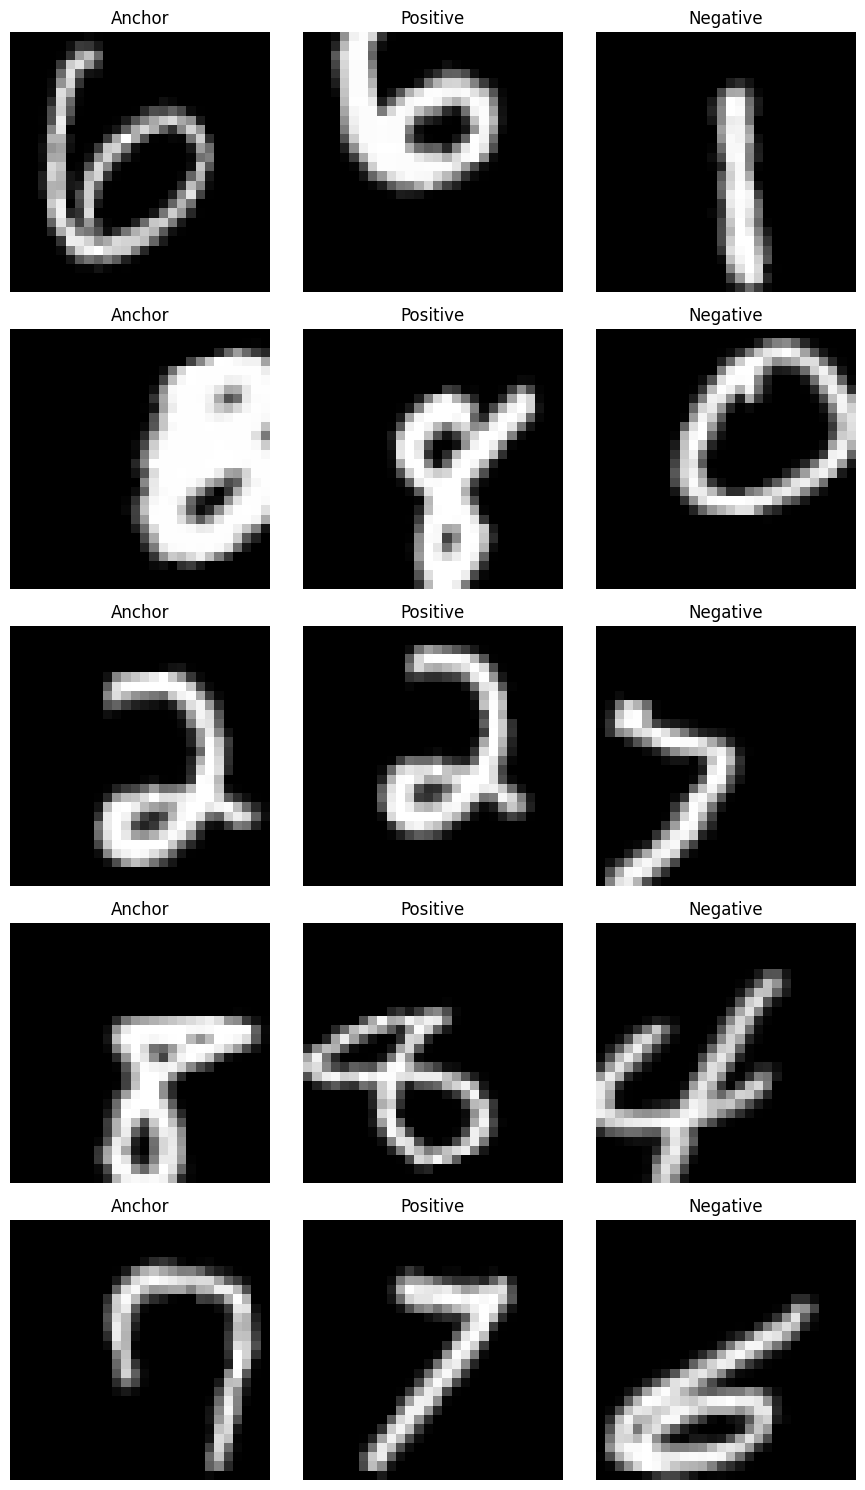

In [25]:
plot_image_triplets(train_triplets)

# Triplet Neural Networks

### Model Architectures

In [26]:
def simple_embedding_model(input_shape, embedding_dim=128):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(input_layer, x, name='simple_embedding_model')

def complex_embedding_model(input_shape, embedding_dim=256):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(input_layer, x, name='complex_embedding_model')

def more_complex_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(1e-4))(x)
    return Model(input_layer, x, name='more_complex_embedding_model')

def improved_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal())(input_layer)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAvgPool2D()(x)
    x = Dropout(0.5)(x) 
    x = Dense(embedding_dim, activation='relu')(x)
    
    return Model(input_layer, x, name='improved_embedding_model')

def pretrained_embedding_model(input_shape, embedding_dim=256):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 
    
    input_layer = Input(shape=input_shape, name='input_image')
    x = base_model(input_layer)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(0.001))(x)
    return Model(input_layer, x, name='pretrained_embedding_model')

### Loss functions

In [27]:
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        pos_dist, neg_dist = y_pred[0], y_pred[1]
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

### Distance Layers

In [28]:
def euclidean_distance(embeddings):
    return tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=1) + tf.keras.backend.epsilon())

def cosine_similarity(embeddings):
    return 1 - tf.keras.losses.cosine_similarity(embeddings[0], embeddings[1])

Added the epsilon since very small square roots will result in Nan values, which will result in Nan values for the loss function.

## Triplet Model

In [29]:
def create_triplet_network(input_shape, embedding_model_func, embedding_dim=128):
    embedding_model = embedding_model_func(input_shape, embedding_dim)
    
    input_anchor = Input(shape=input_shape, name='input_anchor')
    input_positive = Input(shape=input_shape, name='input_positive')
    input_negative = Input(shape=input_shape, name='input_negative')
    
    processed_anchor = embedding_model(input_anchor)
    processed_positive = embedding_model(input_positive)
    processed_negative = embedding_model(input_negative)
    
    pos_dist = Lambda(euclidean_distance, name='pos_dist')([processed_anchor, processed_positive])
    neg_dist = Lambda(euclidean_distance, name='neg_dist')([processed_anchor, processed_negative])
    
    triplet_network = Model(inputs=[input_anchor, input_positive, input_negative], 
                            outputs=[pos_dist, neg_dist])
    
    return triplet_network, embedding_model

In [97]:
train_triplets[0][0].shape

(28, 28, 1)

In [98]:
input_shape = (28, 28, 1)       #MNIST Data
#input_shape = train_triplets[0][0].shape

embedding_dim = 256

triplet_network, embedding_model = create_triplet_network(input_shape, 
                                                          complex_embedding_model, 
                                                          embedding_dim)

In [99]:
embedding_model.summary()

Model: "complex_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,456 (1.66 MB)

 Trainable params: 435,456 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
triplet_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0), 
                        loss=triplet_loss(margin=10))

train_triplets, val_triplets = train_test_split(train_triplets, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

dummy_labels = np.zeros((train_triplets.shape[0],))

history = triplet_network.fit(
    [train_triplets[:, 0], train_triplets[:, 1], train_triplets[:, 2]],  
    dummy_labels,
    epochs=50,
    validation_data=([val_triplets[:, 0], val_triplets[:, 1], val_triplets[:, 2]], dummy_labels[:val_triplets.shape[0]]), 
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.2332 - val_loss: 9.5481
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 10.1824 - val_loss: 9.4827
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.0683 - val_loss: 9.3906
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 11.2254 - val_loss: 9.3637
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.9641 - val_loss: 9.3751
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.0220 - val_loss: 9.2872
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 12.6230 - val_loss: 9.3047
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 10.1986 - val_loss: 9.2793
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 12.9102 - val_loss: 9.3384
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 13.8506 - val_loss: 9.3232
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.1543 - val_loss: 9.2670
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - los

In [ ]:
embedding_model.save('models/Siamese-CIFAR-more_complex/embedding_model.keras')

In [ ]:
embedding_model = load_model('models/Siamese-CIFAR-more_complex/embedding_model.keras')

In [102]:
embedding_model.summary()

Model: "complex_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,456 (1.66 MB)

 Trainable params: 435,456 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

## Hard Triplets

In [63]:
def hard_triplet_mining(anchor_embeddings, positive_embeddings, negative_embeddings, margin=1.0):
    pos_dist = tf.reduce_sum(tf.square(anchor_embeddings - positive_embeddings), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor_embeddings - negative_embeddings), axis=1)
    
    hard_triplets_mask = pos_dist + margin > neg_dist
    return hard_triplets_mask

In [36]:
def train_with_hard_triplets(triplet_network, embedding_model, triplets, margin=1.0, batch_size=32, epochs=50, val_triplets=None):
    for epoch in range(epochs):
        num_batches = len(triplets) // batch_size
        progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")
        
        for batch_idx in progress_bar:
            batch_triplets = triplets[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            
            anchor_images = batch_triplets[:, 0]
            positive_images = batch_triplets[:, 1]
            negative_images = batch_triplets[:, 2]
            
            anchor_embeddings = embedding_model(anchor_images)
            positive_embeddings = embedding_model(positive_images)
            negative_embeddings = embedding_model(negative_images)
            
            hard_triplet_mask = hard_triplet_mining(anchor_embeddings, positive_embeddings, negative_embeddings, margin)
            hard_triplets = batch_triplets[hard_triplet_mask]
            
            if len(hard_triplets) > 0:
                triplet_network.train_on_batch(
                    [hard_triplets[:, 0], hard_triplets[:, 1], hard_triplets[:, 2]],
                    np.zeros((len(hard_triplets),))
                )
        
        print(f'Epoch {epoch + 1}/{epochs} completed')
        
        if val_triplets is not None:
            val_labels = np.zeros((val_triplets.shape[0],))
            val_loss = triplet_network.evaluate([val_triplets[:, 0], val_triplets[:, 1], val_triplets[:, 2]], val_labels)
            print(f'Validation loss after epoch {epoch + 1}: {val_loss:.4f}')

In [42]:
input_shape = (28, 28, 1)       #MNIST Data
#input_shape = train_triplets[0][0].shape
embedding_dim = 256

# Initialize triplet network and embedding model
#triplet_network, embedding_model = create_triplet_network(input_shape, improved_embedding_model, embedding_dim)

#triplet_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0), 
                        loss=triplet_loss(margin=1.0))

# Split the data
#train_triplets, val_triplets = train_test_split(train_triplets, test_size=0.2, random_state=42)

# Train with hard triplet mining
#train_with_hard_triplets(triplet_network, embedding_model, train_triplets, margin=0.5, batch_size=32, epochs=50, val_triplets=val_triplets)

Epoch 1/50:  11%|███                          | 4/38 [00:01<00:11,  2.86batch/s]


KeyboardInterrupt: 

### Visualising Embeddings

#### Training Images

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


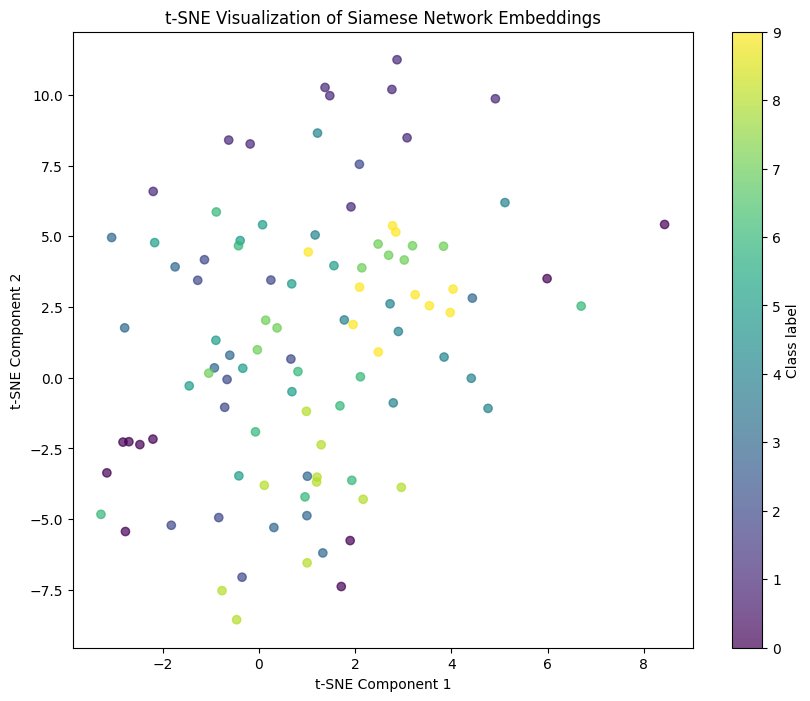

In [103]:
train_embeddings = embedding_model.predict(reduced_x_train)

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_2d[:, 0]+np.random.normal(0,1,size=len(train_embeddings)), train_embeddings_2d[:, 1]+np.random.normal(0,1,size=len(train_embeddings)), c=reduced_y_train, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Siamese Network Embeddings')
plt.show()

#### Validation Images

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


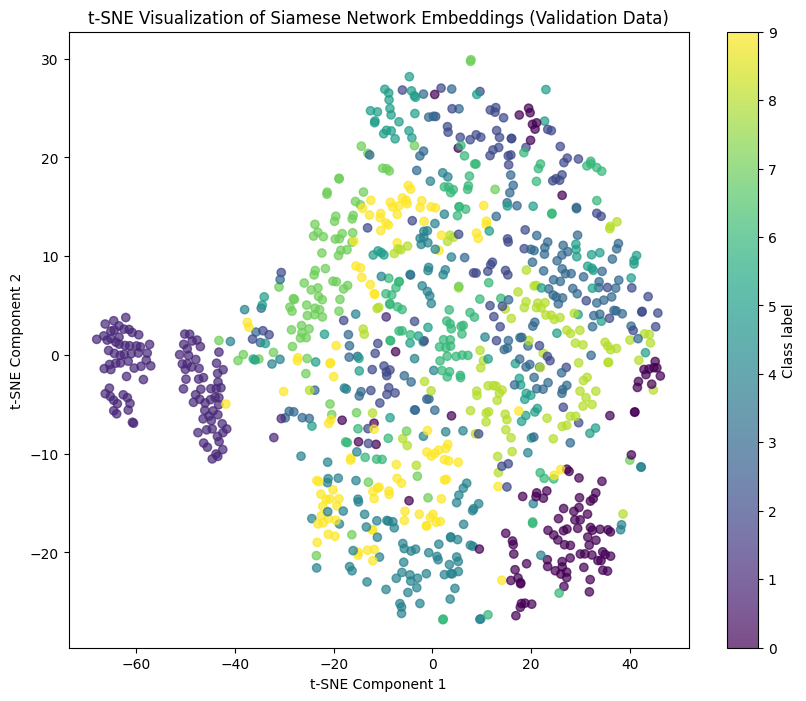

In [104]:
np.random.seed(42)
sample_indices = np.random.choice(x_val.shape[0], size=1000, replace=False)
x_val_sampled = x_val[sample_indices]
y_val_sampled = y_val[sample_indices]

val_embeddings = embedding_model.predict(x_val_sampled)

tsne = TSNE(n_components=2, random_state=42)
val_embeddings_2d = tsne.fit_transform(val_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], c=y_val_sampled, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Siamese Network Embeddings (Validation Data)')
plt.show()

## Predictive Model -> KNN

In [105]:
train_embeddings.shape

(100, 256)

In [106]:
knn = KNeighborsClassifier(n_neighbors=3)

In [107]:
knn.fit(train_embeddings, reduced_y_train)

KNeighborsClassifier(n_neighbors=3)

In [108]:
val_embeddings = embedding_model.predict(x_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [109]:
y_pred = knn.predict(val_embeddings)

In [110]:
print(accuracy_score(y_val, y_pred))

0.6014


In [111]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71       980
           1       0.88      0.99      0.93      1135
           2       0.38      0.56      0.45      1032
           3       0.56      0.54      0.55      1010
           4       0.56      0.44      0.50       982
           5       0.46      0.49      0.47       892
           6       0.78      0.47      0.59       958
           7       0.72      0.61      0.66      1028
           8       0.64      0.51      0.57       974
           9       0.55      0.50      0.52      1009

    accuracy                           0.60     10000
   macro avg       0.61      0.59      0.59     10000
weighted avg       0.62      0.60      0.60     10000



## Transfer Learning

In [ ]:
def build_transfer_learning_model(embedding_model, num_classes):
    embedding_model.trainable = True
    
    input_layer = embedding_model.input
    x = embedding_model.output
    x = Dense(128, activation='relu')(x)  
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)  
    
    transfer_model = Model(inputs=input_layer, outputs=output_layer)
    return transfer_model

In [ ]:
#input_shape = (28, 28, 1)         #MNIST data
input_shape = x_train.shape[1:]

num_classes = len(np.unique(reduced_y_train))

train_labels_one_hot = to_categorical(reduced_y_train, num_classes)

In [ ]:
transfer_model = build_transfer_learning_model(embedding_model, num_classes)

In [ ]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

In [ ]:
history = transfer_model.fit(reduced_x_train, train_labels_one_hot, 
                             epochs=100, batch_size=32)